In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub
path = kagglehub.dataset_download("hijest/englishrussian-dictionary-for-machine-translate")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'englishrussian-dictionary-for-machine-translate' dataset.
Path to dataset files: /kaggle/input/englishrussian-dictionary-for-machine-translate


In [ ]:
import string
import re
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pandas as pd

# Путь к вашему файлу
text = "/kaggle/input/englishrussian-dictionary-for-machine-translate/rus.txt"

# Чтение файла и обработка строк
with open(text, encoding='utf-8') as file:
    lines = file.read().split("\n")

pairs = []

for line in lines:
    # Ищем разделитель табуляции
    parts = line.split("\t")
    if len(parts) >= 2:
        english, russian = parts[0], parts[1]
        # Добавляем специальные токены для начала и конца предложения
        russian = "[start] " + russian + " [end]"
        pairs.append((english, russian))

In [ ]:
df = pd.DataFrame(pairs)
df.head(20)

,0,1
0,Go.,[start] Марш! [end]
1,Go.,[start] Иди. [end]
2,Go.,[start] Идите. [end]
3,Hi.,[start] Здравствуйте. [end]
4,Hi.,[start] Привет! [end]
5,Hi.,[start] Хай. [end]
6,Hi.,[start] Здрасте. [end]
7,Hi.,[start] Здоро́во! [end]
8,Run!,[start] Беги! [end]
9,Run!,[start] Бегите! [end]


In [ ]:
import random
print(random.choice(pairs))
print(len(pairs))

('Keep looking.', '[start] Смотрите дальше. [end]')
363386


In [ ]:
random.shuffle(pairs)
num_val_samples = int(0.2 * len(pairs))
num_train_samples = len(pairs) - 2 * num_val_samples
train_pairs = pairs[:num_train_samples]
val_pairs = pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = pairs[num_train_samples + num_val_samples:]

In [ ]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

218032
72677
72677


In [ ]:
strip_chars = string.punctuation + "." + "," + "?" + "!"

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [ ]:
custom_standardization(pairs)

<tf.Tensor: shape=(363386, 2), dtype=string, numpy=
array([[b'theres only one problem',
        b'start \xd0\x95\xd1\x81\xd1\x82\xd1\x8c \xd1\x82\xd0\xbe\xd0\xbb\xd1\x8c\xd0\xba\xd0\xbe \xd0\xbe\xd0\xb4\xd0\xbd\xd0\xb0 \xd0\xbf\xd1\x80\xd0\xbe\xd0\xb1\xd0\xbb\xd0\xb5\xd0\xbc\xd0\xb0 end'],
       [b'tom is hypocritical',
        b'start \xd0\xa2\xd0\xbe\xd0\xbc  \xd0\xbb\xd0\xb8\xd1\x86\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x80 end'],
       [b'i live alone in this house',
        b'start \xd0\xaf \xd0\xb6\xd0\xb8\xd0\xb2\xd1\x83 \xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbd \xd0\xb2 \xd1\x8d\xd1\x82\xd0\xbe\xd0\xbc \xd0\xb4\xd0\xbe\xd0\xbc\xd0\xb5 end'],
       ...,
       [b'tom said mary was nervous',
        b'start \xd0\xa2\xd0\xbe\xd0\xbc \xd1\x81\xd0\xba\xd0\xb0\xd0\xb7\xd0\xb0\xd0\xbb \xd1\x87\xd1\x82\xd0\xbe \xd0\x9c\xd1\x8d\xd1\x80\xd0\xb8 \xd0\xbd\xd0\xb5\xd1\x80\xd0\xb2\xd0\xbd\xd0\xb8\xd1\x87\xd0\xb0\xd0\xb5\xd1\x82 end'],
       [b'will you give me a job',
        b'start \xd0\xa2\xd1\x8b \xd0\

In [ ]:
from keras import layers
vocab_size = 30000
sequence_length = 30 #было 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_russian_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_russian_texts)

In [ ]:
batch_size = 64

def format_dataset(eng,rus):
    eng = source_vectorization(eng)
    rus = target_vectorization(rus)
    return ({
        "english": eng,
        "russian": rus[:, :-1],
    }, rus[:, 1:])

In [ ]:
def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['russian'].shape: {inputs['russian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 30)
inputs['russian'].shape: (64, 30)
targets.shape: (64, 30)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="russian")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

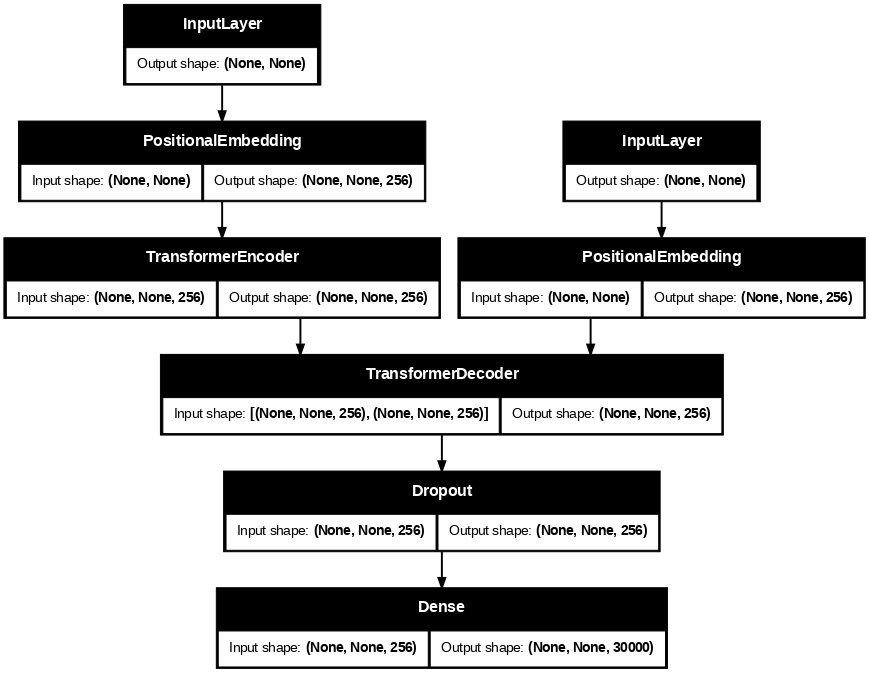

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 476s 134ms/step - accuracy: 0.8518 - loss: 1.2636 - val_accuracy: 0.9110 - val_loss: 0.5707
Epoch 2/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 438s 129ms/step - accuracy: 0.9089 - loss: 0.5918 - val_accuracy: 0.9238 - val_loss: 0.4558
Epoch 3/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 443s 130ms/step - accuracy: 0.9198 - loss: 0.4946 - val_accuracy: 0.9278 - val_loss: 0.4284
Epoch 4/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 444s 130ms/step - accuracy: 0.9251 - loss: 0.4526 - val_accuracy: 0.9297 - val_loss: 0.4173
Epoch 5/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 444s 130ms/step - accuracy: 0.9286 - loss: 0.4275 - val_accuracy: 0.9315 - val_loss: 0.4072


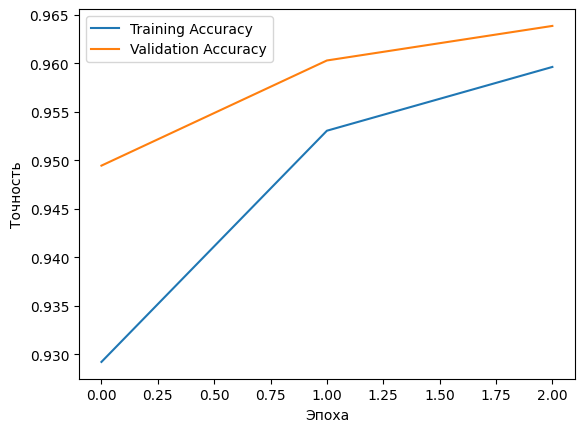

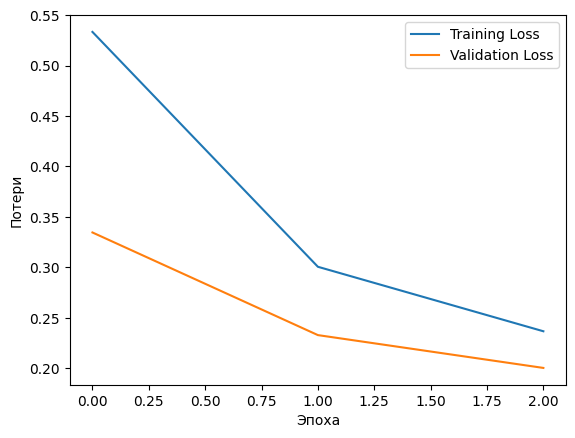

In [ ]:
import matplotlib.pyplot as plt
# Построение графика точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 30 #было 20

# Функция транслита
def simple_translit(word):
    translit_map = {
        'a':'а','b':'б','v':'в','g':'г','d':'д','e':'е','yo':'ё',
        'zh':'ж','z':'з','i':'и','j':'й','k':'к','l':'л','m':'м',
        'n':'н','o':'о','p':'п','r':'р','s':'с','t':'т','u':'у',
        'f':'ф','h':'х','ts':'ц','ch':'ч','sh':'ш','shch':'щ','y':'ы',
        'ye':'е','yu':'ю','ya':'я'
    }
    return ''.join([translit_map.get(ch, ch) for ch in word])

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]

        if sampled_token == "[end]":
            break

        if sampled_token == "[UNK]":
            # Взять последнее слово из входного предложения для транслита
            last_word = input_sentence.split()[-1]
            translit_word = simple_translit(last_word)
            decoded_sentence += " " + translit_word
        else:
            decoded_sentence += " " + sampled_token
    return decoded_sentence

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I have a brother named Tom.
[start] У меня есть брат Том end              
-
I had a stroke last year.
[start] В прошлом году я был ыеар. end             
-
You're really useless.
[start] Вы действительно уселесс. end                
-
Tom has recovered.
[start] У Тома реcоверед. end                
-
You must stay here.
[start] Ты должен остаться здесь end               
-
Stay far away from that dog.
[start] Не стой из Бостона end               
-
Tom asked Mary to give him some money.
[start] Том попросил Мэри дать ему денег end             
-
I'm not gonna lie to you.
[start] Я тебе не врать end               
-
I told Tom I'd take care of him.
[start] Я сказал Тому что у него о ему бы end          
-
Tom said he read a lot of interesting books over the summer.
[start] Том сказал что читал много книг end             


In [ ]:
def translate(text):
    print(text)
    print(decode_sequence(text))
translate("how are you my friend")
translate("do you want sleep")
translate("my computer too old to start this game")
translate("The cat was lying peacefully on the windows ill, soaking up the warm sunlight. Its soft fur shimmered in the light, and it seemed completely relaxed. With gentle paws tucked under its body, the cat purred softly, enjoying a quiet afternoon nap.")

how are you my friend
[start] Как ты мой друг end               
do you want sleep
[start] Ты хочешь спать end                
my computer too old to start this game
[start] Мой компьютер слишком старый эту игру end             
The cat was lying peacefully on the windows ill, soaking up the warm sunlight. Its soft fur shimmered in the light, and it seemed completely relaxed. With gentle paws tucked under its body, the cat purred softly, enjoying a quiet afternoon nap.
[start] Кот не лгал на нап. за нап. нап. нап. нап. нап. end        


In [ ]:
translate("i like my cat")
translate("i like google")

i like my cat
[start] Мне нравится мой кот end               
i like google
[start] Мне нравится гоогле end                


In [ ]:
# Сохраняем модель
model.save("/content/model1.h5")
# Сохраняем векторизаторы
import pickle
with open('/content/source_vectorization1.pkl', 'wb') as f:
    pickle.dump(source_vectorization, f)
with open('/content/target_vectorization1.pkl', 'wb') as f:
    pickle.dump(target_vectorization, f)
#другой вариант
import joblib
joblib.dump(source_vectorization, 'source_vectorization1.joblib')
joblib.dump(target_vectorization, 'target_vectorization1.joblib')
